# Import libraries

In [87]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [88]:
path = pathlib.Path('D:\Data Science\Real-Time-Data-Analysis\data\\raw\data-v1.csv')

df = pd.read_csv(path,index_col='index',parse_dates=True)

# Looking into data

In [89]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
index,,,,,,
2022-08-01 09:30:00,19.360001,19.525000,19.350000,19.455000,19.455000,1543009
2022-08-01 10:30:00,19.459999,19.620001,19.450001,19.620001,19.620001,781953
2022-08-01 11:30:00,19.610001,19.620001,19.504999,19.525000,19.525000,613057
2022-08-01 12:30:00,19.525000,19.540001,19.480000,19.495001,19.495001,734559
2022-08-01 13:30:00,19.500000,19.540001,19.480000,19.530001,19.530001,1195479


In [90]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,455.000000,455.000000,455.000000,455.000000,455.000000,4.550000e+02
mean,18.446047,18.503086,18.395451,18.449305,18.449305,1.160302e+06
std,1.113284,1.102984,1.122986,1.113832,1.113832,9.572886e+05
min,16.424999,16.545000,16.389999,16.424999,16.424999,1.706300e+05
25%,17.514999,17.600000,17.450000,17.525001,17.525001,5.370620e+05
50%,18.365000,18.420000,18.320000,18.365000,18.365000,8.426680e+05
75%,19.390000,19.435000,19.347500,19.392500,19.392500,1.486831e+06
max,20.485001,20.600000,20.440001,20.485001,20.485001,8.628966e+06


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2022-08-01 09:30:00 to 2022-10-31 15:30:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       455 non-null    float64
 1   High       455 non-null    float64
 2   Low        455 non-null    float64
 3   Close      455 non-null    float64
 4   Adj Close  455 non-null    float64
 5   Volume     455 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 24.9 KB


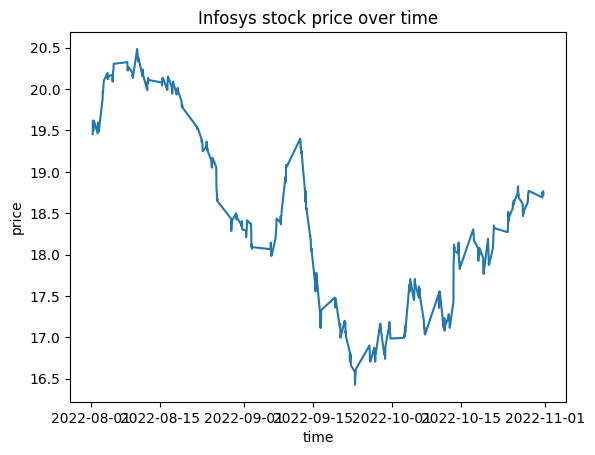

In [92]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

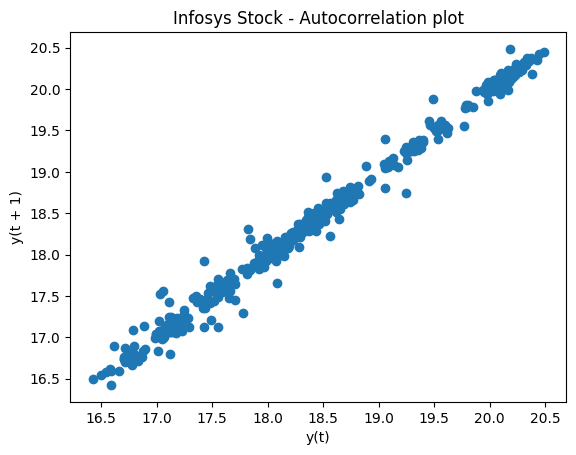

In [93]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [94]:
from statsmodels.tsa.stattools import adfuller

In [95]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -1.2103346134224993
2. P-value : 0.6691342969517478


## ## We find our series is non-stationary.

In [96]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [97]:
from statsmodels.graphics.tsaplots import plot_acf

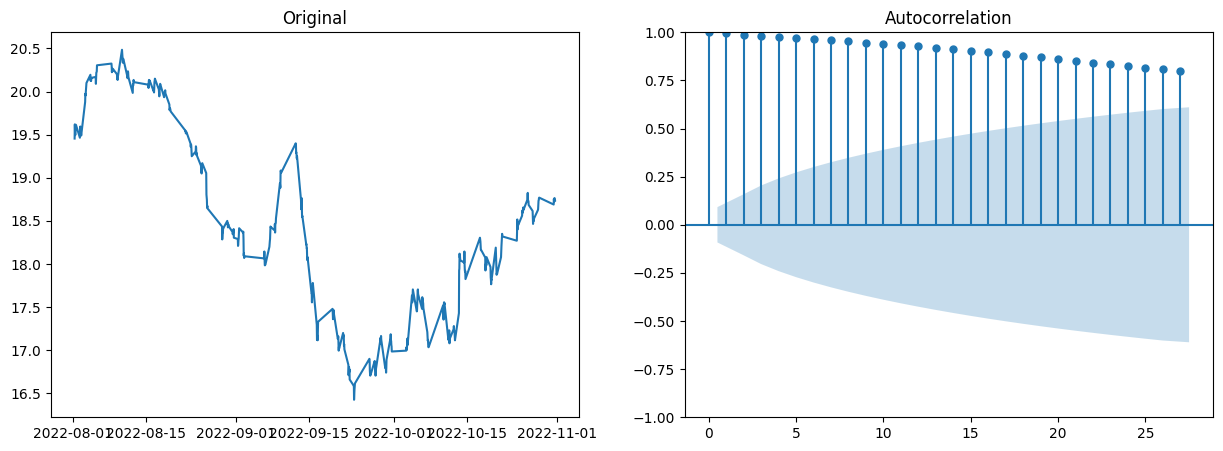

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

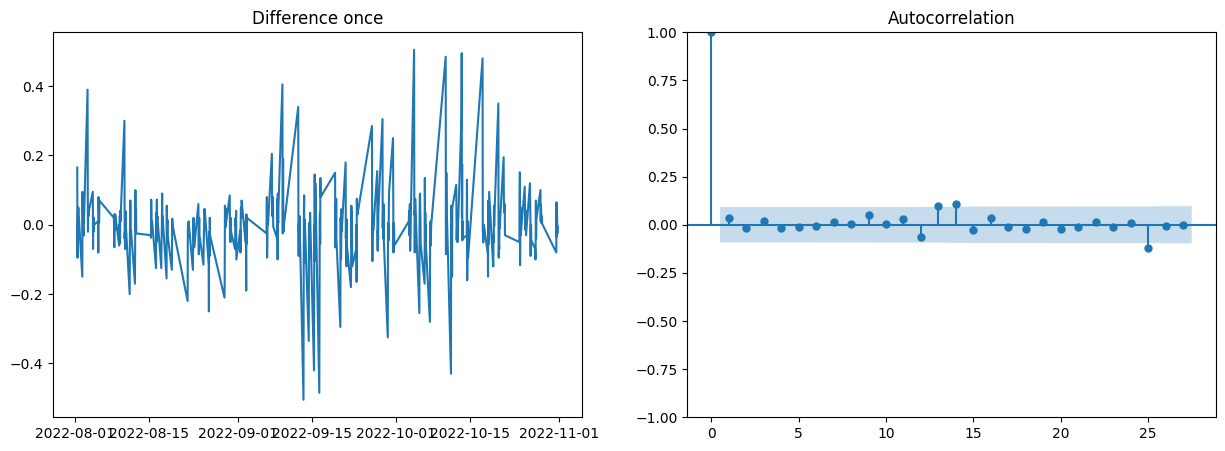

In [51]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

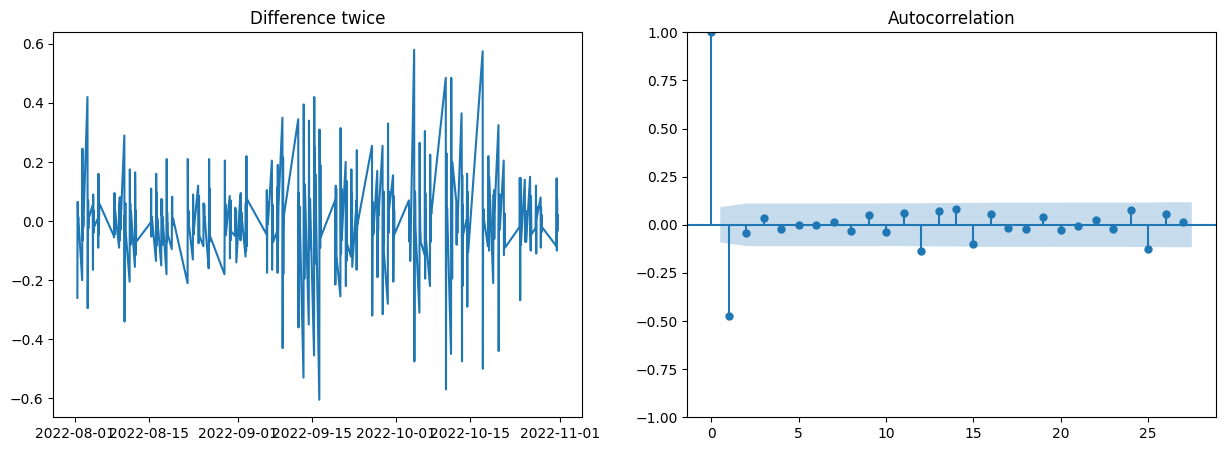

In [99]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

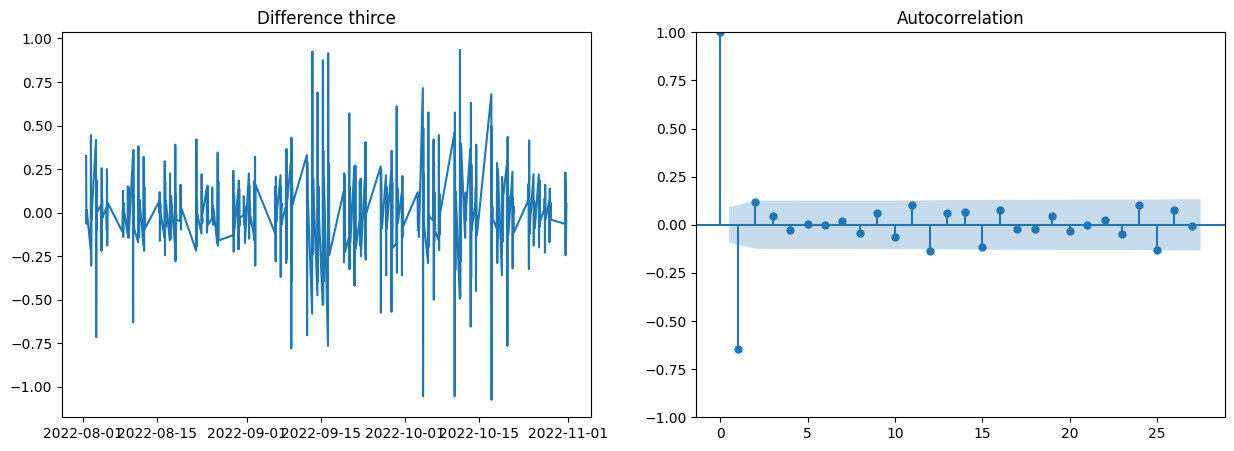

In [100]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference thirce')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 2 is good.

## Another way

We can use pmdarima package to find differencing.

In [101]:
from pmdarima.arima.utils import ndiffs

In [102]:
ndiffs(df['Close'], test='adf')

1

It's saying 1 is good.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [103]:
from statsmodels.graphics.tsaplots import plot_pacf

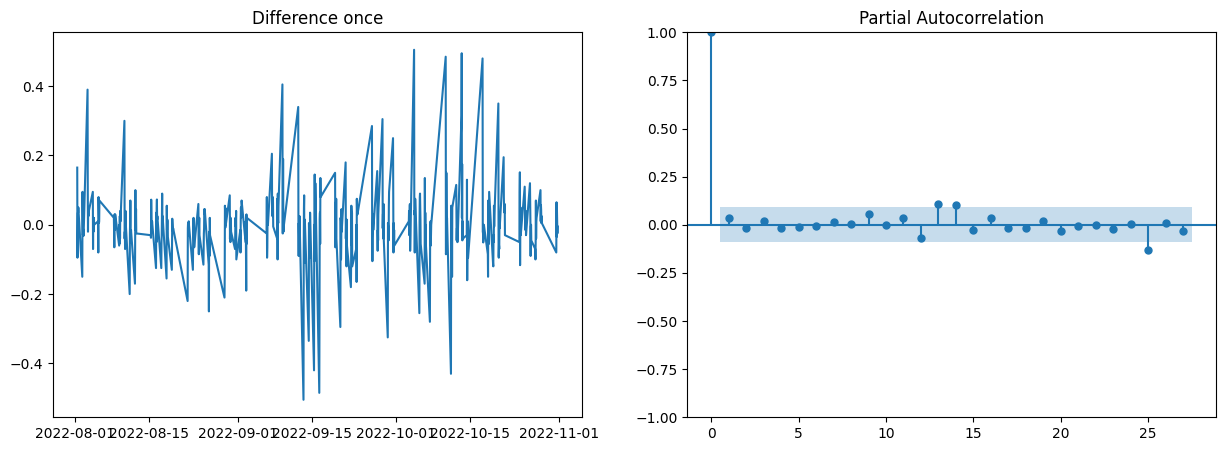

In [104]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

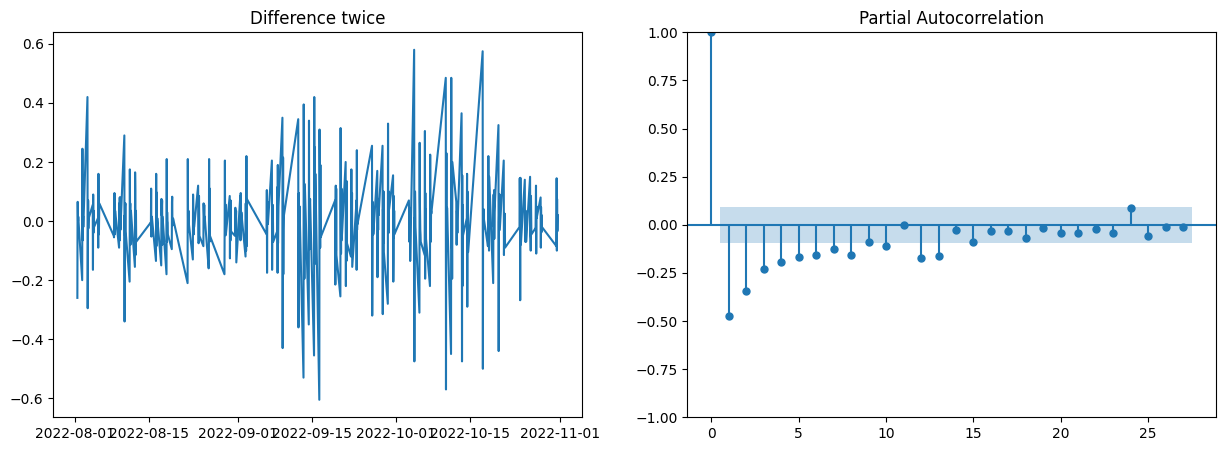

In [105]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_pacf(diff, ax=ax2);

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

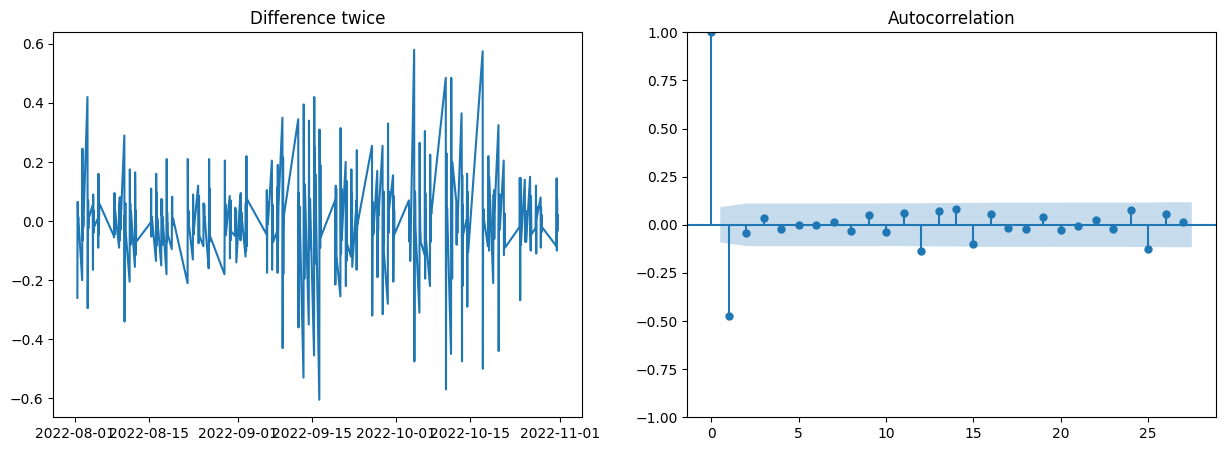

In [106]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

In [108]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True, start_P=1, start_q=1)
# stepswise_fit.summary()

In [109]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

training_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.014106942665213116


In [110]:
model = ARIMA(history, order=(2,2,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  455
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 364.478
Date:                Mon, 14 Nov 2022   AIC                           -720.956
Time:                        08:31:11   BIC                           -704.493
Sample:                             0   HQIC                          -714.469
                                - 455                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0313      0.049      0.639      0.523      -0.065       0.127
ar.L2         -0.0199      0.069     -0.290      0.771      -0.155       0.115
ma.L1         -0.9902      0.010   -100.235      0.000      -1.010      -0.971
sigma2         0.0116      0.000     31.376      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               960.77
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
start= len(train_data)
end = len(train_data)+len(test_data)-1
pred = model_fit.predict(start=start, end= end, typ='levels')

MSE_error = mean_squared_error(test_data, pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.0137586576392401


In [112]:
print(end)

454


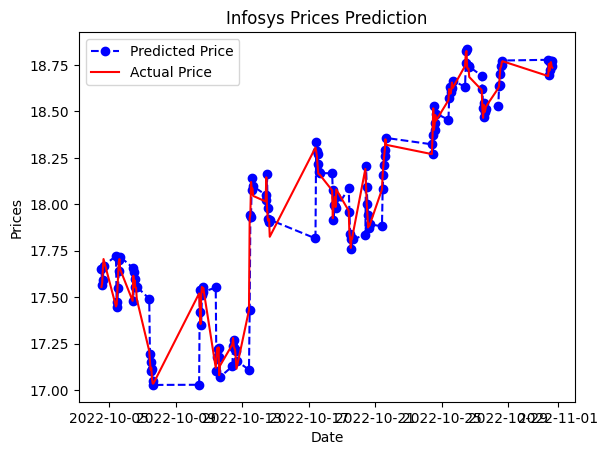

In [113]:
test_set_range = df[int(len(df)*0.7):]
plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
plt.title('Infosys Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

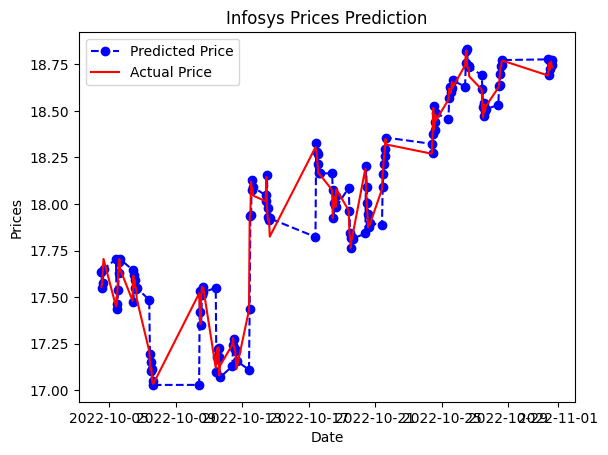

In [114]:
test_set_range = df[int(len(df)*0.7):]
plt.plot(test_set_range.index, pred, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
plt.title('Infosys Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

In [115]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
index,,,,,,
2022-10-31 11:30:00,18.754999,18.760,18.684999,18.719999,18.719999,695776
2022-10-31 12:30:00,18.725000,18.760,18.680000,18.760000,18.760000,481401
2022-10-31 13:30:00,18.750000,18.785,18.735001,18.764999,18.764999,1341238
2022-10-31 14:30:00,18.760000,18.830,18.719999,18.740000,18.740000,1686403
2022-10-31 15:30:00,18.740000,18.770,18.709999,18.735001,18.735001,1805751


In [177]:
history = [x for x in df['Close'].values]

model2 = ARIMA(history, order=(0,1,0))
model_fit2 = model2.fit()
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  455
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 368.231
Date:                Mon, 14 Nov 2022   AIC                           -734.462
Time:                        09:21:37   BIC                           -730.344
Sample:                             0   HQIC                          -732.840
                                - 455                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0116      0.000     32.173      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               980.25
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [178]:
future_index = pd.date_range(start='2022-11-01 09:30:00', end='2022-11-01 22:00:00', freq='1H')

In [179]:
future_index[:10]

DatetimeIndex(['2022-11-01 09:30:00', '2022-11-01 10:30:00',
               '2022-11-01 11:30:00', '2022-11-01 12:30:00',
               '2022-11-01 13:30:00', '2022-11-01 14:30:00',
               '2022-11-01 15:30:00', '2022-11-01 16:30:00',
               '2022-11-01 17:30:00', '2022-11-01 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [180]:
start= len(train_data)
end = len(train_data)+len(future_index)-1
pred = model_fit2.predict(start=start, end= end, typ='levels')

In [181]:
print(len(future_index))
print(len(pred))

13
13


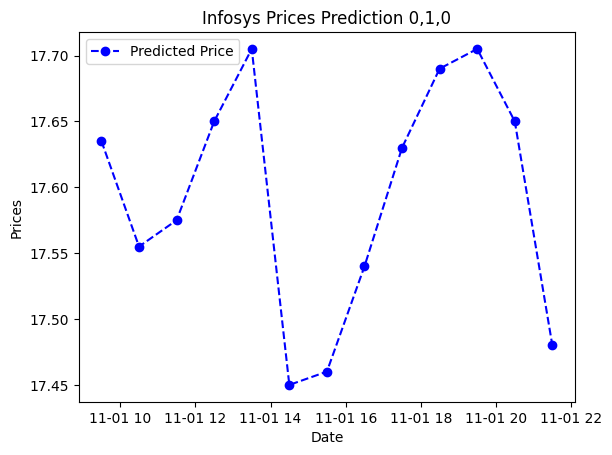

In [182]:
plt.plot(future_index, pred, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Infosys Prices Prediction 0,1,0')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()